In [1]:
import copy
from pprint import pprint
import numpy as np
from c3.model import Model
from c3.c3objs import Quantity
from c3.parametermap import ParameterMap
from c3.experiment import Experiment
from c3.generator.generator import Generator
from c3.signal import gates, pulse
from c3.generator import devices
from c3.libraries import chip, hamiltonians, envelopes

# Optimal Control

In [2]:
dressed = True
qubit_lvls = 3
freq = 5e9
anhar = -210e6
init_temp = 0
qubit_temp = 0
t_final = 7e-9  # Time for single qubit gates
sim_res = 100e9
awg_res = 2e9
sideband = 50e6
lo_freq = 5e9 + sideband

# ### MAKE MODEL
q1 = chip.Qubit(
    name="Q1",
    desc="Qubit 1",
    freq=Quantity(
        value=freq,
        min_val=4.995e9,
        max_val=5.005e9,
        unit="Hz 2pi",
    ),
    anhar=Quantity(
        value=anhar,
        min_val=-380e6,
        max_val=-120e6,
        unit="Hz 2pi",
    ),
    hilbert_dim=qubit_lvls,
    temp=Quantity(value=qubit_temp, min_val=0.0, max_val=0.12, unit="K"),
)

drive = chip.Drive(
    name="d1",
    desc="Drive 1",
    comment="Drive line 1 on qubit 1",
    connected=["Q1"],
    hamiltonian_func=hamiltonians.x_drive,
)
phys_components = [q1]
line_components = [drive]

model = Model(phys_components, line_components)
model.set_dressed(dressed)

In [3]:
generator = Generator(
    devices={
        "LO": devices.LO(name="lo", resolution=sim_res, outputs=1),
        "AWG": devices.AWG(name="awg", resolution=awg_res, outputs=1),
        "DigitalToAnalog": devices.DigitalToAnalog(
            name="dac", resolution=sim_res, inputs=1, outputs=1
        ),
        "Mixer": devices.Mixer(name="mixer", inputs=2, outputs=1),
        "VoltsToHertz": devices.VoltsToHertz(
            name="v_to_hz",
            V_to_Hz=Quantity(value=1e9, min_val=0.9e9, max_val=1.1e9, unit="Hz/V"),
            inputs=1,
            outputs=1,
        ),
    },
    chains={
        "d1": {
            "LO": [],
            "AWG": [],
            "DigitalToAnalog": ["AWG"],
            "Mixer": ["LO", "DigitalToAnalog"],
            "VoltsToHertz": ["Mixer"],
        }
    },
)
generator.devices["AWG"].enable_drag_2()

In [4]:
gauss_params_single = {
    "amp": Quantity(value=0.45, min_val=0.35, max_val=0.5, unit="V"),
    "t_final": Quantity(
        value=t_final, min_val=0.5 * t_final, max_val=1.5 * t_final, unit="s"
    ),
    "sigma": Quantity(
        value=t_final / 4, min_val=t_final / 8, max_val=t_final / 2, unit="s"
    ),
    "xy_angle": Quantity(
        value=0.0, min_val=-0.5 * np.pi, max_val=2.5 * np.pi, unit="rad"
    ),
    "freq_offset": Quantity(
        value=-sideband - 0.5e6,
        min_val=-60 * 1e6,
        max_val=-40 * 1e6,
        unit="Hz 2pi",
    ),
    "delta": Quantity(value=-1, min_val=-5, max_val=3, unit=""),
}

gauss_env_single = pulse.Envelope(
    name="gauss",
    desc="Gaussian comp for single-qubit gates",
    params=gauss_params_single,
    shape=envelopes.gaussian_nonorm,
)
nodrive_env = pulse.Envelope(
    name="no_drive",
    params={
        "t_final": Quantity(
            value=t_final, min_val=0.5 * t_final, max_val=1.5 * t_final, unit="s"
        )
    },
    shape=envelopes.no_drive,
)
carrier_parameters = {
    "freq": Quantity(
        value=lo_freq,
        min_val=4.5e9,
        max_val=6e9,
        unit="Hz 2pi",
    ),
    "framechange": Quantity(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit="rad"),
}
carr = pulse.Carrier(
    name="carrier",
    desc="Frequency of the local oscillator",
    params=carrier_parameters,
)

rx90p = gates.Instruction(
    name="rx90p", t_start=0.0, t_end=t_final, channels=["d1"], targets=[0]
)
QId = gates.Instruction(
    name="id", t_start=0.0, t_end=t_final, channels=["d1"], targets=[0]
)

rx90p.add_component(gauss_env_single, "d1")
rx90p.add_component(carr, "d1")
QId.add_component(nodrive_env, "d1")
QId.add_component(copy.deepcopy(carr), "d1")
QId.comps["d1"]["carrier"].params["framechange"].set_value(
    (-sideband * t_final) % (2 * np.pi)
)
ry90p = copy.deepcopy(rx90p)
ry90p.name = "ry90p"
rx90m = copy.deepcopy(rx90p)
rx90m.name = "rx90m"
ry90m = copy.deepcopy(rx90p)
ry90m.name = "ry90m"
ry90p.comps["d1"]["gauss"].params["xy_angle"].set_value(0.5 * np.pi)
rx90m.comps["d1"]["gauss"].params["xy_angle"].set_value(np.pi)
ry90m.comps["d1"]["gauss"].params["xy_angle"].set_value(1.5 * np.pi)

parameter_map = ParameterMap(
    instructions=[QId, rx90p, ry90p, rx90m, ry90m], model=model, generator=generator
)

# ### MAKE EXPERIMENT
simulation = Experiment(pmap=parameter_map)

In [5]:
gateset_opt_map =   [
    [
      ("rx90p[0]", "d1", "gauss", "amp"),
      ("ry90p[0]", "d1", "gauss", "amp"),
      ("rx90m[0]", "d1", "gauss", "amp"),
      ("ry90m[0]", "d1", "gauss", "amp")
    ],
    [
      ("rx90p[0]", "d1", "gauss", "delta"),
      ("ry90p[0]", "d1", "gauss", "delta"),
      ("rx90m[0]", "d1", "gauss", "delta"),
      ("ry90m[0]", "d1", "gauss", "delta")
    ],
    [
      ("rx90p[0]", "d1", "gauss", "freq_offset"),
      ("ry90p[0]", "d1", "gauss", "freq_offset"),
      ("rx90m[0]", "d1", "gauss", "freq_offset"),
      ("ry90m[0]", "d1", "gauss", "freq_offset")
    ],
    [
      ("rx90p[0]", "d1", "carrier", "framechange"),
      ("ry90p[0]", "d1", "carrier", "framechange"),
      ("rx90m[0]", "d1", "carrier", "framechange"),
      ("ry90m[0]", "d1", "carrier", "framechange")
    ]
  ]

parameter_map.set_opt_map(gateset_opt_map)

In [6]:
parameter_map.print_parameters()

rx90p[0]-d1-gauss-amp                 : 450.000 mV 
ry90p[0]-d1-gauss-amp
rx90m[0]-d1-gauss-amp
ry90m[0]-d1-gauss-amp

rx90p[0]-d1-gauss-delta               : -1.000  
ry90p[0]-d1-gauss-delta
rx90m[0]-d1-gauss-delta
ry90m[0]-d1-gauss-delta

rx90p[0]-d1-gauss-freq_offset         : -50.500 MHz 2pi 
ry90p[0]-d1-gauss-freq_offset
rx90m[0]-d1-gauss-freq_offset
ry90m[0]-d1-gauss-freq_offset

rx90p[0]-d1-carrier-framechange       : 0.000 rad 
ry90p[0]-d1-carrier-framechange
rx90m[0]-d1-carrier-framechange
ry90m[0]-d1-carrier-framechange




### Dynamics

To investigate dynamics, we define the ground state as an initial state.

In [7]:
import tensorflow as tf

In [8]:
psi_init = [[0] * 3]
psi_init[0][0] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))

In [9]:
init_state

<tf.Tensor: shape=(3, 1), dtype=complex128, numpy=
array([[1.+0.j],
       [0.+0.j],
       [0.+0.j]])>

Since we stored the process matrices, we can now relatively inexpesively evaluate sequences. We start with just one gate

In [10]:
barely_a_seq = ['rx90p[0]']

and plot system dynamics.

In [11]:
import matplotlib.pyplot as plt

def plot_dynamics(exp, psi_init, seq, goal=-1):
        """
        Plotting code for time-resolved populations.

        Parameters
        ----------
        psi_init: tf.Tensor
            Initial state or density matrix.
        seq: list
            List of operations to apply to the initial state.
        goal: tf.float64
            Value of the goal function, if used.
        debug: boolean
            If true, return a matplotlib figure instead of saving.
        """
        model = exp.pmap.model
        dUs = exp.partial_propagators
        psi_t = psi_init.numpy()
        pop_t = exp.populations(psi_t, model.lindbladian)
        for gate in seq:
            for du in dUs[gate]:
                psi_t = np.matmul(du.numpy(), psi_t)
                pops = exp.populations(psi_t, model.lindbladian)
                pop_t = np.append(pop_t, pops, axis=1)

        fig, axs = plt.subplots(1, 1)
        ts = exp.ts
        dt = ts[1] - ts[0]
        ts = np.linspace(0.0, dt*pop_t.shape[1], pop_t.shape[1])
        axs.plot(ts / 1e-9, pop_t.T)
        axs.grid(linestyle="--")
        axs.tick_params(
            direction="in", left=True, right=True, top=True, bottom=True
        )
        axs.set_xlabel('Time [ns]')
        axs.set_ylabel('Population')
        plt.legend(model.state_labels)
        pass

In [12]:
simulation.set_opt_gates("rx90p[0]")
simulation.compute_propagators()

{'rx90p[0]': <tf.Tensor: shape=(3, 3), dtype=complex128, numpy=
 array([[ 0.58787842-0.08273557j, -0.10158596-0.79751265j,
          0.0315141 -0.01464672j],
        [-0.1017262 -0.79749737j,  0.5902584 -0.06618626j,
          0.02346579-0.01770536j],
        [ 0.03147998-0.01457847j,  0.02349759-0.01778005j,
         -0.99896223+0.00163568j]])>}

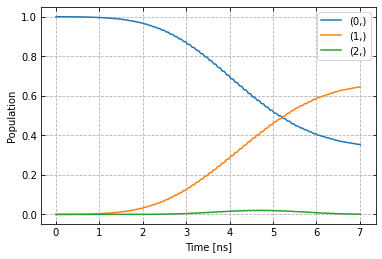

In [13]:
plot_dynamics(simulation, init_state, barely_a_seq)

### Qiskit circuit with unoptimized gates

In [14]:
# Qiskit related modules
from c3.qiskit import C3Provider
from c3.qiskit.c3_gates import RX90pGate
from qiskit import QuantumCircuit
from qiskit.tools.visualization import plot_histogram

In [15]:
qc = QuantumCircuit(1)
qc.append(RX90pGate(), [0])
c3_provider = C3Provider()
c3_backend = c3_provider.get_backend("c3_qasm_physics_simulator")
qiskit_exp = copy.deepcopy(simulation)
c3_backend.set_c3_experiment(qiskit_exp)
c3_job_unopt = c3_backend.run(qc)
result_unopt = c3_job_unopt.result()
res_pops_unopt = result_unopt.data()["state_pops"]
print("Result from unoptimized gates:") 
pprint(res_pops_unopt)

No classical registers in circuit "circuit-0", counts will be empty.


Result from unoptimized gates:
{'(0,)': 0.35244620561242473,
 '(1,)': 0.6463502734117926,
 '(2,)': 0.001203520975806626}


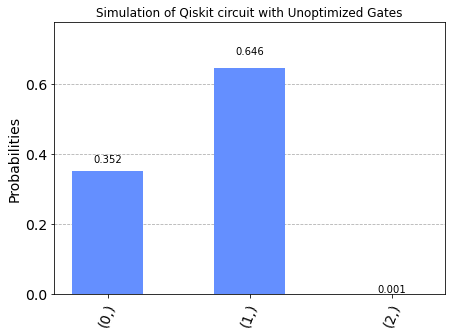

In [16]:
plot_histogram(res_pops_unopt, title='Simulation of Qiskit circuit with Unoptimized Gates')

In [17]:
import os
import tempfile
from c3.optimizers.optimalcontrol import OptimalControl
from c3.libraries.fidelities import unitary_infid_set
from c3.libraries.algorithms import lbfgs

# Create a temporary directory to store logfiles, modify as needed
log_dir = os.path.join(tempfile.TemporaryDirectory().name, "c3logs")

opt = OptimalControl(
    dir_path=log_dir,
    fid_func=unitary_infid_set,
    fid_subspace=["Q1"],
    pmap=parameter_map,
    algorithm=lbfgs,
    options={"maxfun" : 150},
    run_name="better_X90"
)
opt.set_exp(simulation)

In [18]:
opt.optimize_controls()

C3:STATUS:Saving as: /var/folders/04/np4lgk2d7sq6w0dpn758sgp80000gn/T/tmpy161_98t/c3logs/better_X90/2022_04_30_T_14_03_00/open_loop.c3log


2022-04-30 14:03:03.945477: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-30 14:03:03.980026: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


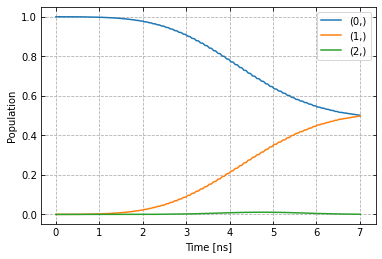

In [19]:
simulation.compute_propagators()
plot_dynamics(simulation, init_state, barely_a_seq)

In [20]:
opt.current_best_goal

0.0006429346364070776

In [21]:
parameter_map.print_parameters()

rx90p[0]-d1-gauss-amp                 : 376.655 mV 
ry90p[0]-d1-gauss-amp
rx90m[0]-d1-gauss-amp
ry90m[0]-d1-gauss-amp

rx90p[0]-d1-gauss-delta               : -954.644 m 
ry90p[0]-d1-gauss-delta
rx90m[0]-d1-gauss-delta
ry90m[0]-d1-gauss-delta

rx90p[0]-d1-gauss-freq_offset         : -50.333 MHz 2pi 
ry90p[0]-d1-gauss-freq_offset
rx90m[0]-d1-gauss-freq_offset
ry90m[0]-d1-gauss-freq_offset

rx90p[0]-d1-carrier-framechange       : -1.479 mrad 
ry90p[0]-d1-carrier-framechange
rx90m[0]-d1-carrier-framechange
ry90m[0]-d1-carrier-framechange




### Qiskit circuit with Optimized gates

In [22]:
qiskit_exp = copy.deepcopy(simulation)
c3_backend.set_c3_experiment(qiskit_exp)
c3_job_unopt = c3_backend.run(qc)
result_unopt = c3_job_unopt.result()
res_pops_unopt = result_unopt.data()["state_pops"]
print("Result from unoptimized gates:") 
pprint(res_pops_unopt)

No classical registers in circuit "circuit-0", counts will be empty.


Result from unoptimized gates:
{'(0,)': 0.5008471433309696,
 '(1,)': 0.498331206748105,
 '(2,)': 0.0008216499209478669}


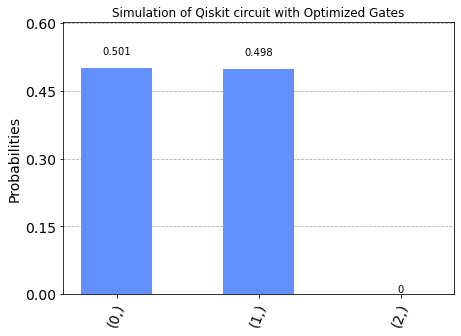

In [23]:
plot_histogram(res_pops_unopt, title='Simulation of Qiskit circuit with Optimized Gates')

# Simulated calibration

Calibration of control pulses is the process of fine-tuning parameters in a feedback-loop with the experiment. We will simulate this process here by constructing a black-box simulation and interacting with it exactly like an experiment.

We have manange imports and creation of the black-box the same way as in the previous example in a helper `single_qubit_blackbox_exp.py`.

In [24]:
from single_qubit_experiment import create_experiment

blackbox = create_experiment()

This blackbox is constructed the same way as in the C1 example. The difference will be in how we interact with it. First, we decide on what experiment we want to perform and need to specify it as a python function. A general, minimal example would be

```
def exp_communication(params):
    # Send parameters to experiment controller
    # and recieve a measurement result.
    return measurement_result
 ```

Again, `params` is a linear vector of bare numbers. The measurement result can be a single number or a set of results. It can also include additional information about statistics, like averaging, standard deviation, etc.

### ORBIT - Single-length randomized benchmarking
The following defines an [ORBIT](https://arxiv.org/abs/1403.0035) procedure. In short, we define sequences of gates that result in an identity gate if our individual gates are perfect. Any deviation from identity gives us a measure of the imperfections in our gates. Our helper `qt_utils` provides these sequences.

In [25]:
from c3.utils import qt_utils

In [26]:
qt_utils.single_length_RB(
            RB_number=1, RB_length=5, target=0
    )

[['rx90p[0]',
  'ry90p[0]',
  'ry90p[0]',
  'ry90p[0]',
  'rx90p[0]',
  'rx90p[0]',
  'ry90p[0]',
  'rx90p[0]',
  'rx90p[0]',
  'rx90p[0]',
  'ry90p[0]',
  'ry90p[0]',
  'rx90p[0]',
  'rx90m[0]']]

The desired number of 5 gates is selected from a specific set (the Clifford group) and has to be decomposed into the available gate-set. Here, this means 4 gates per Clifford, hence a sequence of 20 gates.

### Communication with the experiment
Some of the following code is specific to the fact that this a *simulated* calibration. The interface of $C^2$ to the experiment is simple: parameters in $\rightarrow$ results out. Thus, we have to wrap the blackbox by defining the target states and the `opt_map`.

In [27]:
import numpy as np
import tensorflow as tf

def ORBIT_wrapper(p):
    def ORBIT(params, exp, opt_map, qubit_labels, logdir):    
        ### ORBIT meta-parameters ###
        RB_length = 60 # How long each sequence is
        RB_number = 40  # How many sequences
        shots = 1000    # How many averages per readout

        ################################
        ### Simulation specific part ###
        ################################

        do_noise = False  # Whether to add artificial noise to the results

        qubit_label = list(qubit_labels.keys())[0]
        state_labels = qubit_labels[qubit_label]
        state_label = [tuple(l) for l in state_labels]

        # Creating the RB sequences #
        seqs = qt_utils.single_length_RB(
                RB_number=RB_number, RB_length=RB_length, target=0
        )

        # Transmitting the parameters to the experiment #
        exp.pmap.set_parameters(params, opt_map)
        exp.set_opt_gates_seq(seqs)

        # Simulating the gates #
        U_dict = exp.compute_propagators()

        # Running the RB sequences and read-out the results #
        pops = exp.evaluate(seqs, init_state)
        pop1s, _ = exp.process(pops, labels=state_label)

        results = []
        results_std = []
        shots_nums = []

        # Collecting results and statistics, add noise #
        if do_noise:
            for p1 in pop1s:
                draws = tf.keras.backend.random_binomial(
                    [shots],
                    p=p1[0],
                    dtype=tf.float64,
                )
                results.append([np.mean(draws)])
                results_std.append([np.std(draws)/np.sqrt(shots)])
                shots_nums.append([shots])
        else:
            for p1 in pop1s:
                results.append(p1.numpy())
                results_std.append([0])
                shots_nums.append([shots])

        #######################################
        ### End of Simulation specific part ###
        #######################################

        goal = np.mean(results)
        return goal, results, results_std, seqs, shots_nums
    return ORBIT(
                p, blackbox, gateset_opt_map, state_labels, "/tmp/c3logs/blackbox"
            )

### Optimization
We first import algorithms and the correct optimizer object.

In [28]:
from c3.libraries.algorithms import cmaes
from c3.optimizers.calibration import Calibration

### Representation of the experiment within $C^3$
At this point we have to make sure that the gates ("RX90p", etc.) and drive line ("d1") are compatible to the experiment controller operating the blackbox. We mirror the blackbox by creating an experiment in the $C^3$ context:

It is important to note that in this example, we are transmitting only these four parameters to the experiment. We don't know how the blackbox will implement the pulse shapes and care has to be taken that the parameters are understood on the other end. Optionally, we could specifiy a virtual AWG within $C^3$ and transmit pixilated pulse shapes directly to the physiscal AWG.

### Algorithms
As an optimization algoritm, we choose [CMA-Es](https://en.wikipedia.org/wiki/CMA-ES) and set up some options specific to this algorithm.

#### Maximum Evaluations
We set the maximum number of evaluations to 30 for quick demonstration. Ideally around 250 function evaluations are useful for a good optimization. See [docs](https://c3-toolset.readthedocs.io/en/latest/Simulated_calibration.html#analysis) for a longer run.

In [29]:
alg_options = {
    "popsize" : 10,
    "maxfevals" : 300,
    "init_point" : "True",
    "tolfun" : 0.01,
    "spread" : 0.1
  }

We define the subspace as both excited states $\{|1>,|2>\}$, assuming read-out can distinguish between 0, 1 and 2.

In [30]:
state_labels = {
      "excited" : [(1,), (2,)]
  }

In the real world, this setup needs to be handled in the experiment controller side.
We construct the optimizer object with the options we setup:

In [31]:
# Create a temporary directory to store logfiles, modify as needed
log_dir = "c3example_calibration"

opt = Calibration(
    dir_path=log_dir,
    run_name="ORBIT_cal",
    eval_func=ORBIT_wrapper,
    pmap=parameter_map,
    exp_right=simulation,
    algorithm=cmaes,
    options=alg_options
)

And run the calibration:

In [32]:
x = parameter_map.get_parameters_scaled()

In [33]:
opt.optimize_controls()

C3:STATUS:Saving as: /Users/anuragsaharoy/dev/c3/examples/c3example_calibration/ORBIT_cal/2022_04_30_T_14_03_05/calibration.log
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 4 (seed=466665, Sat Apr 30 14:03:05 2022)
C3:STATUS:Adding initial point to CMA sample.


/opt/homebrew/Caskroom/miniforge/base/envs/c3-dev/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: input x0 should be a list or 1-D array, trying to flatten (4, 1)-array ()
  warnings.warn(msg + ' (' +


Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 1.652096402235950e-01 1.0e+00 8.09e-02  7e-02  8e-02 0:01.2
    2     21 1.274902409486816e-01 1.2e+00 7.83e-02  7e-02  8e-02 0:02.2
    3     31 1.143488741738468e-01 1.3e+00 7.98e-02  6e-02  9e-02 0:03.3
    6     61 1.227472010521015e-01 1.8e+00 4.94e-02  3e-02  5e-02 0:06.4
   10    101 1.239477936792902e-01 3.5e+00 4.12e-02  1e-02  5e-02 0:10.6
   15    151 9.621991905551633e-02 5.3e+00 2.78e-02  7e-03  2e-02 0:15.8
   21    211 7.308512838391157e-02 7.1e+00 2.49e-02  4e-03  2e-02 0:22.0
   28    281 6.434560522992909e-02 1.5e+01 1.87e-02  3e-03  2e-02 0:29.3
   30    301 7.621433065112128e-02 1.7e+01 1.83e-02  3e-03  2e-02 0:31.5
termination on maxfevals=300
final/bestever f-value = 7.621433e-02 6.434561e-02
incumbent solution: [-0.49660640379480997, -0.05292567725789398, 0.11523346752735714, -0.5100669493534269]
std deviation: [0.011298878400918345, 0.012667202001400571, 0.01709108256029099, 0.0

## Analysis
The following code uses matplotlib to create an ORBIT plot from the logfile.

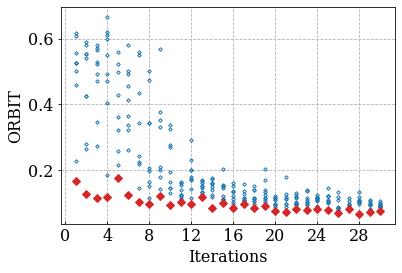

In [34]:
import json
from matplotlib.ticker import MaxNLocator
from  matplotlib import rcParams
from matplotlib import cycler
import matplotlib as mpl
import matplotlib.pyplot as plt

rcParams['xtick.direction'] = 'in'
rcParams['axes.grid'] = True
rcParams['grid.linestyle'] = '--'
rcParams['markers.fillstyle'] = 'none'
rcParams['axes.prop_cycle'] = cycler(
    'linestyle', ["-", "--"]
)

# enable usetex by setting it to True if LaTeX is installed
rcParams['text.usetex'] = False
rcParams['font.size'] = 16
rcParams['font.family'] = 'serif'

logfilename = opt.logdir + "calibration.log"
with open(logfilename, "r") as filename:
    log = filename.readlines()
    

options = json.loads(log[7])

goal_function = []
batch = 0
batch_size = options["popsize"]


eval = 0
for line in log[9:]:
    if line[0] == "{":
        if not eval % batch_size:
            batch = eval // batch_size
            goal_function.append([])
        eval += 1
        point = json.loads(line)
        if 'goal' in point.keys():
            goal_function[batch].append(point['goal'])

# Clean unfinished batch
if len(goal_function[-1])<batch_size:
    goal_function.pop(-1)

fig, ax = plt.subplots(1)
means = []
bests = []
for ii in range(len(goal_function)):
    means.append(np.mean(np.array(goal_function[ii])))
    bests.append(np.min(np.array(goal_function[ii])))
    for pt in goal_function[ii]:
        ax.plot(ii+1, pt, color='tab:blue', marker="D", markersize=2.5, linewidth=0)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel('ORBIT')
ax.set_xlabel('Iterations')
ax.plot(
    range(1, len(goal_function)+1), bests, color="tab:red", marker="D",
    markersize=5.5, linewidth=0, fillstyle='full'
)


# Model Learning on Dataset from a Simulated Experiment

In this notebook, we will use a dataset from a simulated experiment, more specifically, the `Simulated_calibration.ipynb` example notebook and perform Model Learning on a simple 1 qubit model.

### Imports

In [35]:
!pip install -q pandas
import pickle
from pprint import pprint
import copy
import numpy as np
import os
import ast
import hjson
import pandas as pd

from c3.model import Model as Mdl
from c3.c3objs import Quantity as Quantity
from c3.parametermap import ParameterMap as PMap
from c3.experiment import Experiment as Exp
from c3.generator.generator import Generator as Gnr
import c3.signal.gates as gates
import c3.libraries.chip as chip
import c3.generator.devices as devices
import c3.libraries.hamiltonians as hamiltonians
import c3.signal.pulse as pulse
import c3.libraries.envelopes as envelopes
import c3.libraries.tasks as tasks
from c3.optimizers.modellearning import ModelLearning
from c3.optimizers.sensitivity import Sensitivity

## The Dataset

We first take a look below at the dataset and its properties. To explore more details about how the dataset is generated, please refer to the `Simulated_calibration.ipynb` example notebook.

In [36]:
DATAFILE_PATH = "c3example_calibration/recent/dataset.pickle"

In [37]:
with open(DATAFILE_PATH, "rb+") as file:
    data = pickle.load(file)

In [38]:
data.keys()

dict_keys(['seqs_grouped_by_param_set', 'opt_map'])

Since this dataset was obtained from an ORBIT ([arXiv:1403.0035](https://arxiv.org/abs/1403.0035)) calibration experiment, we have the `opt_map` which will tell us about the gateset parameters being optimized.

In [39]:
data["opt_map"]

[['rx90p[0]-d1-gauss-amp',
  'ry90p[0]-d1-gauss-amp',
  'rx90m[0]-d1-gauss-amp',
  'ry90m[0]-d1-gauss-amp'],
 ['rx90p[0]-d1-gauss-delta',
  'ry90p[0]-d1-gauss-delta',
  'rx90m[0]-d1-gauss-delta',
  'ry90m[0]-d1-gauss-delta'],
 ['rx90p[0]-d1-gauss-freq_offset',
  'ry90p[0]-d1-gauss-freq_offset',
  'rx90m[0]-d1-gauss-freq_offset',
  'ry90m[0]-d1-gauss-freq_offset'],
 ['rx90p[0]-d1-carrier-framechange',
  'ry90p[0]-d1-carrier-framechange',
  'rx90m[0]-d1-carrier-framechange',
  'ry90m[0]-d1-carrier-framechange']]

This `opt_map` implies the calibration experiment focussed on optimizing 
the amplitude, delta and frequency offset of the gaussian pulse, along 
with the framechange angle

Now onto the actual measurement data from the experiment runs

In [40]:
seqs_data = data["seqs_grouped_by_param_set"]

**How many experiment runs do we have?**

In [41]:
len(seqs_data)

301

**What does the data from each experiment look like?**

We take a look at the first data point

In [42]:
example_data_point = seqs_data[0]

In [43]:
example_data_point.keys()

dict_keys(['params', 'seqs', 'results', 'results_std', 'shots'])

These `keys` are useful in understanding the structure of the dataset. We look at them one by one.

In [44]:
example_data_point["params"]

[376.655 mV, -954.644 m, -50.333 MHz 2pi, -1.479 mrad]

These are the parameters for our parameterised gateset, for the first experiment run. They correspond to the optimization parameters we previously discussed. 

The `seqs` key stores the sequence of gates that make up this ORBIT calibration experiment. Each ORBIT sequence consists of a set of gates, followed by a measurement operation. This is then repeated for some `n` number of shots (eg, `1000` in this case) and we only store the averaged result along with the standard deviation of these readout shots. Each experiment in turn consists of a number of these ORBIT sequences. The terms *sequence*, *set* and *experiment* are used somewhat loosely here, so we show below what these look like.

**A single ORBIT sequence**

In [45]:
example_data_point["seqs"][0][:10]

['rx90m[0]',
 'rx90p[0]',
 'ry90p[0]',
 'rx90m[0]',
 'rx90p[0]',
 'rx90p[0]',
 'ry90p[0]',
 'ry90p[0]',
 'rx90p[0]',
 'ry90m[0]']

**Total number of ORBIT sequences in an experiment**

In [46]:
len(example_data_point["seqs"])

40

**Total number of Measurement results**

In [47]:
len(example_data_point["results"])

40

**The measurement results and the standard deviation look like this**

In [48]:
example_results = [
    (example_data_point["results"][i], example_data_point["results_std"][i])
    for i in range(len(example_data_point["results"]))
]

In [49]:
pprint(example_results)

[(array([0.2806175]), [0]),
 (array([0.06935928]), [0]),
 (array([0.20866709]), [0]),
 (array([0.08309719]), [0]),
 (array([0.03012492]), [0]),
 (array([0.20113482]), [0]),
 (array([0.23781033]), [0]),
 (array([0.16188531]), [0]),
 (array([0.21895434]), [0]),
 (array([0.2334959]), [0]),
 (array([0.37526485]), [0]),
 (array([0.20934815]), [0]),
 (array([0.25822377]), [0]),
 (array([0.25860026]), [0]),
 (array([0.38984034]), [0]),
 (array([0.20398079]), [0]),
 (array([0.18064832]), [0]),
 (array([0.15982076]), [0]),
 (array([0.15976481]), [0]),
 (array([0.62099746]), [0]),
 (array([0.13190833]), [0]),
 (array([0.14502742]), [0]),
 (array([0.2045203]), [0]),
 (array([0.1894431]), [0]),
 (array([0.10940426]), [0]),
 (array([0.31927472]), [0]),
 (array([0.21695193]), [0]),
 (array([0.50104749]), [0]),
 (array([0.10548841]), [0]),
 (array([0.16478286]), [0]),
 (array([0.08808105]), [0]),
 (array([0.54129509]), [0]),
 (array([0.1750545]), [0]),
 (array([0.23184544]), [0]),
 (array([0.08821276

## The Model for Model Learning

An initial model needs to be provided, which we refine by fitting to our calibration data. We do this below. If you want to learn more about what the various components of the model mean, please refer back to the `two_qubits.ipynb` notebook or the documentation.

In [50]:
exp_opt_map = [[('Q1', 'anhar')], [('Q1', 'freq')]]
parameter_map.set_opt_map(exp_opt_map)

## Optimizer 

In [51]:
datafiles = {"orbit": DATAFILE_PATH} # path to the dataset
run_name = "simple_model_learning" # name of the optimization run
dir_path = "ml_logs" # path to save the learning logs
algorithm = "cma_pre_lbfgs" # algorithm for learning
# this first does a grad-free CMA-ES and then a gradient based LBFGS
options = {
    "cmaes": {
        "popsize": 12,
        "init_point": "True",
        "stop_at_convergence": 10,
        "ftarget": 4,
        "spread": 0.05,
        "stop_at_sigma": 0.01,
    },
    "lbfgs": {"maxfun": 50, "disp": 0},
} # options for the algorithms
sampling = "high_std" # how data points are chosen from the total dataset
batch_sizes = {"orbit": 2} # how many data points are chosen for learning
state_labels = {
    "orbit": [
        [
            1,
        ],
        [
            2,
        ],
    ]
} # the excited states of the qubit model, in this case it is 3-level

In [52]:
opt = ModelLearning(
    datafiles=datafiles,
    run_name=run_name,
    dir_path=dir_path,
    algorithm=algorithm,
    options=options,
    sampling=sampling,
    batch_sizes=batch_sizes,
    state_labels=state_labels,
    pmap=parameter_map,
)

opt.set_exp(simulation)

## Model Learning

We are now ready to learn from the data and improve our model

In [53]:
opt.run()

C3:STATUS:Saving as: /Users/anuragsaharoy/dev/c3/examples/ml_logs/simple_model_learning/2022_04_30_T_14_03_39/model_learn.log
(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 2 (seed=454290, Sat Apr 30 14:03:39 2022)
C3:STATUS:Adding initial point to CMA sample.


/opt/homebrew/Caskroom/miniforge/base/envs/c3-dev/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: input x0 should be a list or 1-D array, trying to flatten (2, 1)-array ()
  warnings.warn(msg + ' (' +


Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     13 8.827340543867486e+01 1.0e+00 3.98e-02  3e-02  3e-02 0:02.7
    2     25 1.450266415534740e+01 1.3e+00 3.58e-02  2e-02  3e-02 0:05.2
    3     37 2.707020554965912e+01 1.5e+00 3.04e-02  2e-02  3e-02 0:07.7
    5     61 2.322439362558192e+01 1.7e+00 1.93e-02  7e-03  1e-02 0:12.8
    7     85 2.093683284532635e+01 3.0e+00 1.11e-02  2e-03  7e-03 0:17.7
   10    121 1.248999003139767e+01 1.0e+01 4.21e-02  6e-03  4e-02 0:25.1
   13    157 2.505734433228872e+00 2.8e+01 8.57e-02  9e-03  1e-01 0:32.5
termination on ftarget=4
final/bestever f-value = 2.505734e+00 2.505734e+00
incumbent solution: [0.314325383431167, 0.14797456210209667]
std deviation: [0.008910479230643125, 0.1371517079271939]
C3:STATUS:Saving as: /Users/anuragsaharoy/dev/c3/examples/ml_logs/simple_model_learning/2022_04_30_T_14_03_39/confirm.log


### Result of Model Learning

In [54]:
opt.current_best_goal

-0.49999999999989164

In [55]:
print(opt.pmap.str_parameters(opt.pmap.opt_map))

Q1-anhar                              : -209.877 MHz 2pi 
Q1-freq                               : 5.001 GHz 2pi 



## Visualisation & Analysis of Results

The Model Learning logs provide a useful way to visualise the learning process and also understand what's going wrong (or right). We now process these logs to read some data points and also plot some visualisations of the Model Learning process

### Open, Clean-up and Convert Logfiles

In [56]:
LOGDIR = opt.logdir

In [57]:
logfile = os.path.join(LOGDIR, "model_learn.log")
with open(logfile, "r") as f:
    log = f.readlines()

In [58]:
params_names = [
    item for sublist in (ast.literal_eval(log[3].strip("\n"))) for item in sublist
]
print(params_names)

['Q1-anhar', 'Q1-freq']


In [59]:
data_list_dict = list()
for line in log[9:]:
    if line[0] == "{":
        temp_dict = ast.literal_eval(line.strip("\n"))
        for index, param_name in enumerate(params_names):
            temp_dict[param_name] = temp_dict["params"][index]
        temp_dict.pop("params")
        data_list_dict.append(temp_dict)

In [60]:
data_df = pd.DataFrame(data_list_dict)

### Summary of Logs

In [61]:
data_df.describe()

,goal,Q1-anhar,Q1-freq
count,178.000000,1.780000e+02,1.780000e+02
mean,78.699228,-2.078441e+08,5.000140e+09
std,89.103948,9.908310e+06,4.102438e+05
min,-0.500000,-2.203251e+08,4.999633e+09
25%,20.954060,-2.092981e+08,4.999899e+09
50%,39.702561,-2.081969e+08,4.999989e+09
75%,123.366511,-2.075892e+08,5.000178e+09
max,666.721291,-7.981706e+07,5.001285e+09


**Best Point**

In [62]:
best_point_file = os.path.join(LOGDIR, 'best_point_model_learn.log')

In [63]:
with open(best_point_file, "r") as f:
    best_point_log_dict = hjson.load(f)

best_point_dict = dict(zip(params_names, best_point_log_dict["optim_status"]["params"]))
best_point_dict["goal"] = best_point_log_dict["optim_status"]["goal"]
print(best_point_dict)

{'Q1-anhar': -209876500.09490532, 'Q1-freq': 5001234000.070027, 'goal': -0.49999999999989164}


### Plotting

We use `matplotlib` to produce the plots below. Please make sure you have the same installed in your python environment.

In [64]:
from matplotlib.ticker import MaxNLocator
from  matplotlib import rcParams
from matplotlib import cycler
import matplotlib as mpl
import matplotlib.pyplot as plt 

In [65]:
rcParams["axes.grid"] = True
rcParams["grid.linestyle"] = "--"

# enable usetex by setting it to True if LaTeX is installed
rcParams["text.usetex"] = False
rcParams["font.size"] = 16
rcParams["font.family"] = "serif"

**In the plots below, the blue line shows the progress of the parameter optimization while the black and the red lines indicate the converged and true value respectively**

### Qubit Anharmonicity

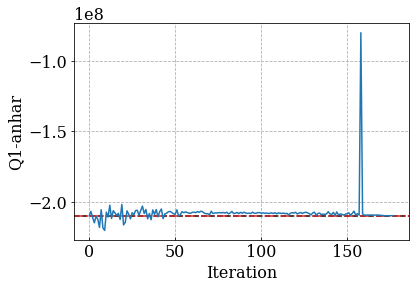

In [66]:
plot_item = "Q1-anhar"
true_value = -210e6

fig, ax = plt.subplots(1)
ax.set_xlabel("Iteration")
ax.set_ylabel(plot_item)
ax.axhline(y=true_value, color="black", linestyle="--")
ax.axhline(y=best_point_dict[plot_item], color="tab:red", linestyle="-.")
ax.plot(data_df[plot_item], color="tab:blue")

### Qubit Frequency

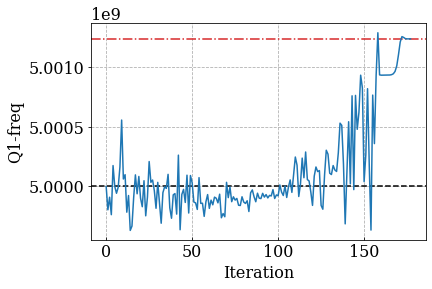

In [67]:
plot_item = "Q1-freq"
true_value = 5e9

fig, ax = plt.subplots(1)
ax.set_xlabel("Iteration")
ax.set_ylabel(plot_item)
ax.axhline(y=true_value, color="black", linestyle="--")
ax.axhline(y=best_point_dict[plot_item], color="tab:red", linestyle="-.")
ax.plot(data_df[plot_item], color="tab:blue")

### Goal Function

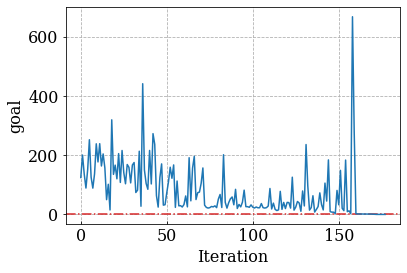

In [68]:
plot_item = "goal"

fig, ax = plt.subplots(1)
ax.set_xlabel("Iteration")
ax.axhline(y=best_point_dict[plot_item], color="tab:red", linestyle="-.")
ax.set_ylabel(plot_item)

ax.plot(data_df[plot_item], color="tab:blue")

# Sensitivity Analysis

Another interesting study to understand if our dataset is indeed helpful in improving certain model parameters is to perform a Sensitivity Analysis. The purpose of this exercise is to scan the Model Parameters of interest (eg, qubit frequency or anharmonicity) across a range of values and notice a prominent dip in the Model Learning Goal Function around the best-fit values

In [69]:
run_name = "Sensitivity"
dir_path = "sensi_logs"
algorithm = "sweep"
options = {"points": 20, "init_point": [-210e6, 5e9]}
sweep_bounds = [
    [-215e6, -205e6],
    [4.9985e9, 5.0015e9],
]

In [70]:
sense_opt = Sensitivity(
    datafiles=datafiles,
    run_name=run_name,
    dir_path=dir_path,
    algorithm=algorithm,
    options=options,
    sampling=sampling,
    batch_sizes=batch_sizes,
    state_labels=state_labels,
    pmap=parameter_map,
    sweep_bounds=sweep_bounds,
    sweep_map=exp_opt_map,
)

sense_opt.set_exp(simulation)

In [71]:
sense_opt.run()

C3:STATUS:Sweeping [['Q1-anhar']]: [-215000000.0, -205000000.0]
C3:STATUS:Saving as: /Users/anuragsaharoy/dev/c3/examples/sensi_logs/Sensitivity/2022_04_30_T_14_04_57/sensitivity.log
C3:STATUS:Sweeping [['Q1-freq']]: [4998500000.0, 5001500000.0]
C3:STATUS:Saving as: /Users/anuragsaharoy/dev/c3/examples/sensi_logs/Sensitivity/2022_04_30_T_14_05_02/sensitivity.log


## Anharmonicity

In [72]:
LOGDIR = sense_opt.logdir_list[0]

In [73]:
logfile = os.path.join(LOGDIR, "sensitivity.log")
with open(logfile, "r") as f:
    log = f.readlines()

In [74]:
data_list_dict = list()
for line in log[9:]:
    if line[0] == "{":
        temp_dict = ast.literal_eval(line.strip("\n"))
        param = temp_dict["params"][0]
        data_list_dict.append({"param": param, "goal": temp_dict["goal"]})

In [75]:
data_df = pd.DataFrame(data_list_dict)

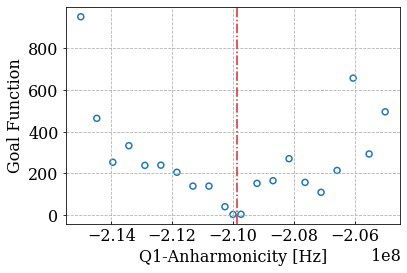

In [76]:
fig, ax = plt.subplots(1)
ax.set_xlabel("Q1-Anharmonicity [Hz]")
ax.set_ylabel("Goal Function")
ax.axvline(x=best_point_dict["Q1-anhar"], color="tab:red", linestyle="-.")
ax.scatter(data_df["param"], data_df["goal"], color="tab:blue")

## Frequency

In [77]:
LOGDIR = sense_opt.logdir_list[1]

In [78]:
logfile = os.path.join(LOGDIR, "sensitivity.log")
with open(logfile, "r") as f:
    log = f.readlines()

In [79]:
data_list_dict = list()
for line in log[9:]:
    if line[0] == "{":
        temp_dict = ast.literal_eval(line.strip("\n"))
        param = temp_dict["params"][0]
        data_list_dict.append({"param": param, "goal": temp_dict["goal"]})

In [80]:
data_df = pd.DataFrame(data_list_dict)

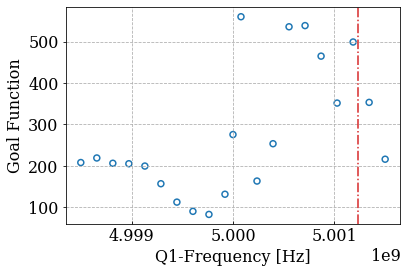

In [81]:
fig, ax = plt.subplots(1)
ax.set_xlabel("Q1-Frequency [Hz]")
ax.set_ylabel("Goal Function")
ax.axvline(x=best_point_dict["Q1-freq"], color="tab:red", linestyle="-.")
ax.scatter(data_df["param"], data_df["goal"], color="tab:blue")